<a href="https://colab.research.google.com/github/Deolinda1506/Project/blob/main/Copy_of_Untitled38.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
%pip install -q torch monai opencv-python-headless PyWavelets numpy scikit-learn einops

Note: you may need to restart the kernel to use updated packages.


In [ ]:
"""Configuration and Helper Functions for Swin-UNETR Carotid Segmentation + IMT Calculation"""
import os
from pathlib import Path
from typing import Dict, List, Optional, Tuple
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
from monai.metrics import DiceMetric

PROJECT_ROOT = Path("/Users/megaapplecenter/Project")
DATA_DIR = PROJECT_ROOT / "carotid"
MODEL_DIR = PROJECT_ROOT / "models"
FIGURES_DIR = PROJECT_ROOT / "figures"
IMT_HIGH_RISK_MM = 0.9
MODEL_DIR.mkdir(exist_ok=True)
FIGURES_DIR.mkdir(exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
RANDOM_STATE = 42


def get_interfaces_from_mask(
    mask: np.ndarray,
    lumen_label: int = 1,
    wall_label: int = 2
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Extract lumen-intima and media-adventitia interfaces from segmentation mask.
    
    Args:
        mask: (H, W) segmentation mask. 0=background, 1=lumen, 2=wall
        lumen_label: Label for lumen class
        wall_label: Label for wall class
        
    Returns:
        lumen_intima: (W,) array of Y-coordinates for lumen-intima interface
        media_adventitia: (W,) array of Y-coordinates for media-adventitia interface
    """
    h, w = mask.shape
    lumen_intima = np.full(w, np.nan)
    media_adventitia = np.full(w, np.nan)
    
    for x in range(w):
        col = mask[:, x]
        lumen_idx = np.where(col == lumen_label)[0]
        wall_idx = np.where(col == wall_label)[0]
        
        if len(lumen_idx) > 0 and len(wall_idx) > 0:
            lumen_center = np.mean(lumen_idx)
            wall_inner = wall_idx[np.argmin(np.abs(wall_idx - lumen_center))]
            lumen_intima[x] = float(wall_inner)
            wall_outer = wall_idx[np.argmax(np.abs(wall_idx - lumen_center))]
            media_adventitia[x] = float(wall_outer)
        elif len(wall_idx) >= 2:
            lumen_intima[x] = float(np.min(wall_idx))
            media_adventitia[x] = float(np.max(wall_idx))
    
    return lumen_intima, media_adventitia


def imt_pixels_per_column(
    lumen_intima: np.ndarray,
    media_adventitia: np.ndarray
) -> np.ndarray:
    """Calculate vertical distance in pixels between interfaces."""
    valid = np.isfinite(lumen_intima) & np.isfinite(media_adventitia)
    thickness = np.abs(media_adventitia - lumen_intima)
    thickness[~valid] = np.nan
    return thickness


def imt_mm_from_mask(
    mask: np.ndarray,
    spacing_mm_per_pixel: float,
    lumen_label: int = 1,
    wall_label: int = 2
) -> float:
    """Calculate mean IMT in mm from segmentation mask."""
    li, ma = get_interfaces_from_mask(mask, lumen_label, wall_label)
    thickness_px = imt_pixels_per_column(li, ma)
    valid = np.isfinite(thickness_px)
    if not np.any(valid):
        return np.nan
    return float(np.nanmean(thickness_px) * spacing_mm_per_pixel)


def imt_mae_mm(pred_masks, true_masks, spacing_mm_per_pixel):
    """Calculate mean absolute error of IMT estimates across a batch."""
    errors = []
    for pred, true in zip(pred_masks, true_masks):
        pred_imt = imt_mm_from_mask(pred, spacing_mm_per_pixel)
        true_imt = imt_mm_from_mask(true, spacing_mm_per_pixel)
        if np.isfinite(pred_imt) and np.isfinite(true_imt):
            errors.append(abs(pred_imt - true_imt))
    return np.mean(errors) if errors else np.nan


In [ ]:
from pathlib import Path
import zipfile

DRIVE_FILE_URL = "https://drive.google.com/file/d/10NZvcIDYZUV8Zy7r7DprvumQox2O8-8d/view?usp=sharing"

zip_candidates = [
    Path("/content/drive/MyDrive/Common Carotid Artery Ultrasound Images.zip"),
    PROJECT_ROOT / "carotid" / "Common Carotid Artery Ultrasound Images.zip",
    Path("data/Common Carotid Artery Ultrasound Images.zip"),
    Path("Common Carotid Artery Ultrasound Images.zip"),
]

zip_path = next((p for p in zip_candidates if p.exists()), None)
extract_dir = Path("/content/data") if Path("/content").exists() else (PROJECT_ROOT / "carotid")
extract_dir.mkdir(parents=True, exist_ok=True)

if zip_path is None and DRIVE_FILE_URL:
    download_target = extract_dir / "Common Carotid Artery Ultrasound Images.zip"
    try:
        import gdown 
    except Exception:
        import subprocess, sys
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "gdown"])
        import gdown

    print("No local zip found. Downloading from Google Drive link...")
    try:
        gdown.download(url=DRIVE_FILE_URL, output=str(download_target), fuzzy=True, quiet=False)
        if download_target.exists() and download_target.stat().st_size > 0:
            zip_path = download_target
    except Exception as e:
        print("Google Drive download failed.")
        print("Reason:", e)
        print("Fix: In Google Drive, set the file to 'Anyone with the link' (Viewer), then retry.")
        print(f"Or place the zip manually at: {extract_dir}/Common Carotid Artery Ultrasound Images.zip")

if zip_path is None:
    print("Dataset zip not found. Add it locally or fix DRIVE_FILE_URL permissions in this cell.")
else:
    with zipfile.ZipFile(zip_path, "r") as zf:
        zf.extractall(extract_dir)
    print(f"Extracted dataset from: {zip_path}")
    print(f"Extraction target: {extract_dir.resolve()}")


Extracted dataset from: /Users/megaapplecenter/Project/carotid/Common Carotid Artery Ultrasound Images.zip
Extraction target: /Users/megaapplecenter/Project/carotid


In [ ]:
from sklearn.model_selection import train_test_split

DATA_ROOT = Path("/content/data/Common Carotid Artery Ultrasound Images") if Path("/content/data/Common Carotid Artery Ultrasound Images").exists() else (PROJECT_ROOT / "carotid" / "Common Carotid Artery Ultrasound Images")

def find_image_mask_pairs(root_path, image_subdir="US images", mask_subdir="Expert mask images", exts=(".png", ".jpg", ".jpeg")):
    root = Path(root_path)
    image_dir = root / image_subdir
    mask_dir = root / mask_subdir
    pairs = []

    for img_path in image_dir.rglob("*"):
        if img_path.suffix.lower() in exts:
            mask_path = mask_dir / img_path.name
            if mask_path.exists():
                pairs.append((str(img_path), str(mask_path)))
    return pairs

def filter_and_flag_pairs(pairs: List[Tuple[str, str]], min_coverage_pct: float, max_coverage_pct: float) -> Tuple[List[Tuple[str, str]], List[Dict]]:
    valid_pairs = []
    flagged = []
    for img_path, mask_path in pairs:
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            flagged.append({"img": img_path, "reason": "Mask file not found or corrupted"})
            continue

        total_pixels = mask.shape[0] * mask.shape[1]
        if total_pixels == 0:
            flagged.append({"img": img_path, "reason": "Mask has zero dimensions"})
            continue

        mask_pixels = np.sum(mask > 0)
        coverage_pct = mask_pixels / total_pixels

        if not (min_coverage_pct <= coverage_pct <= max_coverage_pct):
            flagged.append({"img": img_path, "reason": f"Coverage {coverage_pct:.2f} out of range [{min_coverage_pct:.2f}, {max_coverage_pct:.2f}]"})
        else:
            valid_pairs.append((img_path, mask_path))
    return valid_pairs, flagged

pairs = find_image_mask_pairs(DATA_ROOT)
if not pairs:
    raise FileNotFoundError(f"No image/mask pairs under {DATA_ROOT}.")
print(f"Found {len(pairs)} pairs")

valid_pairs, flagged = filter_and_flag_pairs(pairs, min_coverage_pct=0.001, max_coverage_pct=0.95)
pairs = valid_pairs
if flagged:
    print(f"Flagged {len(flagged)} (removed):")
    for f in flagged[:5]:
        print(f"  - {Path(f['img']).name}: {f['reason']}")
print(f"Valid: {len(pairs)}")

train_val_pairs, test_pairs = train_test_split(pairs, test_size=0.15, random_state=RANDOM_STATE)
train_pairs, val_pairs = train_test_split(train_val_pairs, test_size=(0.15/0.85), random_state=RANDOM_STATE)

print(f"Train: {len(train_pairs)}, Val: {len(val_pairs)}, Test: {len(test_pairs)}")


Found 1100 pairs
Valid: 1100
Train: 770, Val: 165, Test: 165


Mask coverage: min=0.0165, max=0.0453, mean=0.0236
IMT (mm): min=1.441, max=2.142, mean=1.805, high-risk (≥0.9)=100


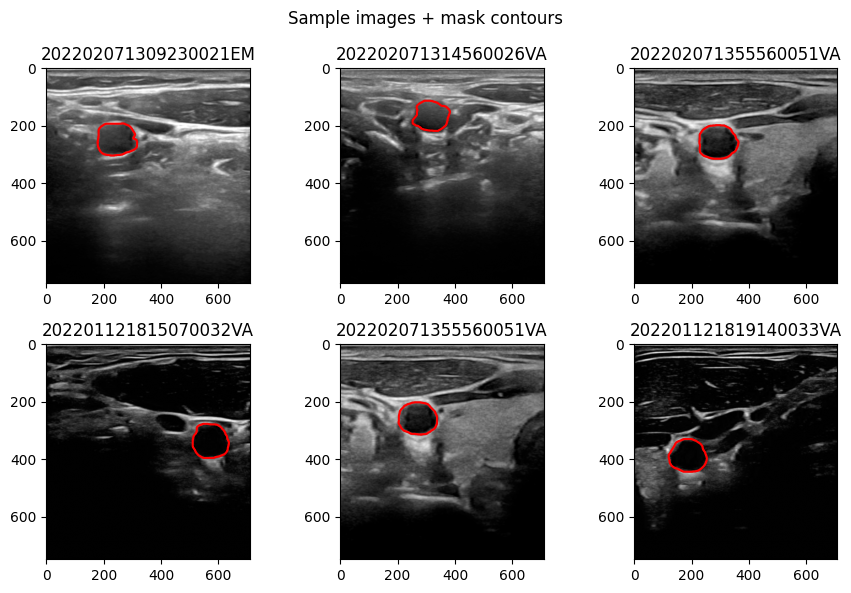

In [ ]:
n_sample = min(100, len(train_pairs))
sample_pairs = np.random.RandomState(RANDOM_STATE).choice(len(train_pairs), n_sample, replace=False)
coverages, imts = [], []
spacing_eda = 0.04
for i in sample_pairs:
    img_path, mask_path = train_pairs[i]
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        img = cv2.imread(img_path)[:, :, 0]
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        mask = cv2.imread(mask_path)[:, :, 0]
    mask_bin = (mask > 127).astype(np.float32)
    coverages.append(np.mean(mask_bin))
    try:
        imt = imt_mm_from_mask(mask_bin.astype(np.int32), spacing_eda, wall_label=1)
        if np.isfinite(imt):
            imts.append(imt)
    except Exception:
        pass
print(f"Mask coverage: min={min(coverages):.4f}, max={max(coverages):.4f}, mean={np.mean(coverages):.4f}")
if imts:
    print(f"IMT (mm): min={min(imts):.3f}, max={max(imts):.3f}, mean={np.mean(imts):.3f}, high-risk (≥{IMT_HIGH_RISK_MM})={sum(1 for x in imts if x >= IMT_HIGH_RISK_MM)}")
try:
    fig, ax = plt.subplots(2, 3, figsize=(9, 6))
    for k, idx in enumerate(sample_pairs[:6]):
        img = cv2.imread(train_pairs[idx][0], cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(train_pairs[idx][1], cv2.IMREAD_GRAYSCALE)
        ax[k//3, k%3].imshow(img, cmap='gray')
        ax[k//3, k%3].contour((mask > 127).astype(float), levels=[0.5], colors=['red'])
        ax[k//3, k%3].set_title(Path(train_pairs[idx][0]).name[:20])
    plt.suptitle('Sample images + mask contours'); plt.tight_layout()
    FIGURES_DIR.mkdir(exist_ok=True)
    plt.savefig(FIGURES_DIR / 'eda_samples.png', dpi=150, bbox_inches='tight')
    plt.show()
except Exception as e:
    print('(matplotlib viz skipped)')


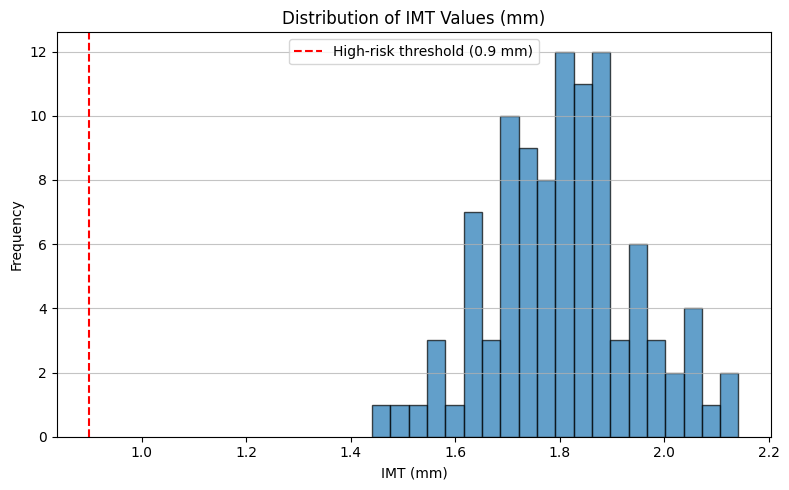

In [ ]:
if 'imts' not in globals() or not imts:
    print("IMT values not found or empty, calculating for histogram.")
    n_sample = min(100, len(train_pairs))
    sample_pairs = np.random.RandomState(RANDOM_STATE).choice(len(train_pairs), n_sample, replace=False)
    imts = []
    spacing_eda = 0.04 

    for i in sample_pairs:
        img_path, mask_path = train_pairs[i]
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            mask_full = cv2.imread(mask_path)
            if mask_full is not None:
                mask = mask_full[:, :, 0] 
            else:
                print(f"Warning: Could not read mask {mask_path}. Skipping.")
                continue

        mask_bin = (mask > 127).astype(np.float32)
        try:
            imt = imt_mm_from_mask(mask_bin.astype(np.int32), spacing_eda, wall_label=1)
            if np.isfinite(imt):
                imts.append(imt)
        except Exception as e:
            print(f"Error calculating IMT for {mask_path}: {e}. Skipping.")
            pass 

if imts:
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    ax.hist(imts, bins=20, edgecolor='black', alpha=0.7)
    ax.set_title('Distribution of IMT Values (mm)')
    ax.set_xlabel('IMT (mm)')
    ax.set_ylabel('Frequency')
    ax.axvline(IMT_HIGH_RISK_MM, color='red', linestyle='--', label=f'High-risk threshold ({IMT_HIGH_RISK_MM} mm)')
    ax.legend()
    plt.grid(axis='y', alpha=0.75)
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'imt_histogram.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("No IMT values available to plot histogram.")


In [11]:
if imts:
    high_risk_samples = sum(1 for x in imts if x >= IMT_HIGH_RISK_MM)
    print(f"Number of samples with IMT >= {IMT_HIGH_RISK_MM} mm (high-risk): {high_risk_samples} out of {len(imts)} total samples.")
else:
    print("No IMT values available to quantify high-risk samples.")

Number of samples with IMT >= 0.9 mm (high-risk): 100 out of 100 total samples.


**Reasoning**:
To confirm that the `sample_pairs` variable holds a representative sample from the training set, I will display the value of `n_sample`, the length of `sample_pairs`, and the first few actual image-mask pairs that `sample_pairs` references from `train_pairs`.



In [12]:
print(f"The desired sample size (n_sample) is: {n_sample}")
print(f"The actual number of sample pairs generated is: {len(sample_pairs)}")
print("\nFirst 5 sample indices:")
print(sample_pairs[:5])

print("\nFirst 5 image-mask paths from train_pairs corresponding to sample_pairs indices:")
for i in sample_pairs[:5]:
    print(f"  Image: {Path(train_pairs[i][0]).name}, Mask: {Path(train_pairs[i][1]).name}")

The desired sample size (n_sample) is: 100
The actual number of sample pairs generated is: 100

First 5 sample indices:
[670 753 727 582 737]

First 5 image-mask paths from train_pairs corresponding to sample_pairs indices:
  Image: 202202071309230021EM VASCULAR_slice_585.png, Mask: 202202071309230021EM VASCULAR_slice_585.png
  Image: 202202071314560026VAS_slice_21.png, Mask: 202202071314560026VAS_slice_21.png
  Image: 202202071355560051VAS_slice_418.png, Mask: 202202071355560051VAS_slice_418.png
  Image: 202201121815070032VAS_slice_465.png, Mask: 202201121815070032VAS_slice_465.png
  Image: 202202071355560051VAS_slice_436.png, Mask: 202202071355560051VAS_slice_436.png


All sampled images have a consistent shape: (749, 709)


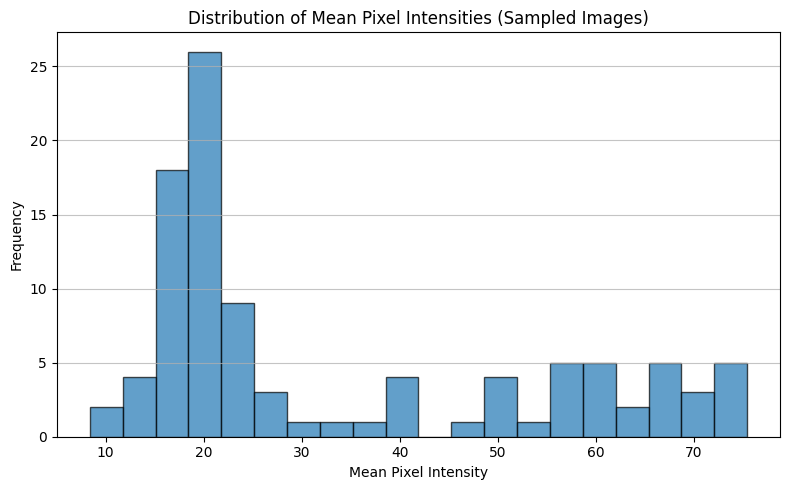

In [ ]:
mean_intensities = []
image_shapes = []

for idx in sample_pairs:
    img_path = train_pairs[idx][0]
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        img_full = cv2.imread(img_path)
        if img_full is not None:
            img = img_full[:, :, 0] 
        else:
            print(f"Warning: Could not read image {img_path}. Skipping.")
            continue

    mean_intensities.append(np.mean(img))
    image_shapes.append(img.shape)

if image_shapes:
    unique_shapes = set(image_shapes)
    if len(unique_shapes) == 1:
        print(f"All sampled images have a consistent shape: {list(unique_shapes)[0]}")
    else:
        print(f"Sampled images have varying shapes: {unique_shapes}")
else:
    print("No image shapes found.")

if mean_intensities:
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    ax.hist(mean_intensities, bins=20, edgecolor='black', alpha=0.7)
    ax.set_title('Distribution of Mean Pixel Intensities (Sampled Images)')
    ax.set_xlabel('Mean Pixel Intensity')
    ax.set_ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'mean_pixel_intensity_histogram.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("No image mean intensities found to plot histogram.")


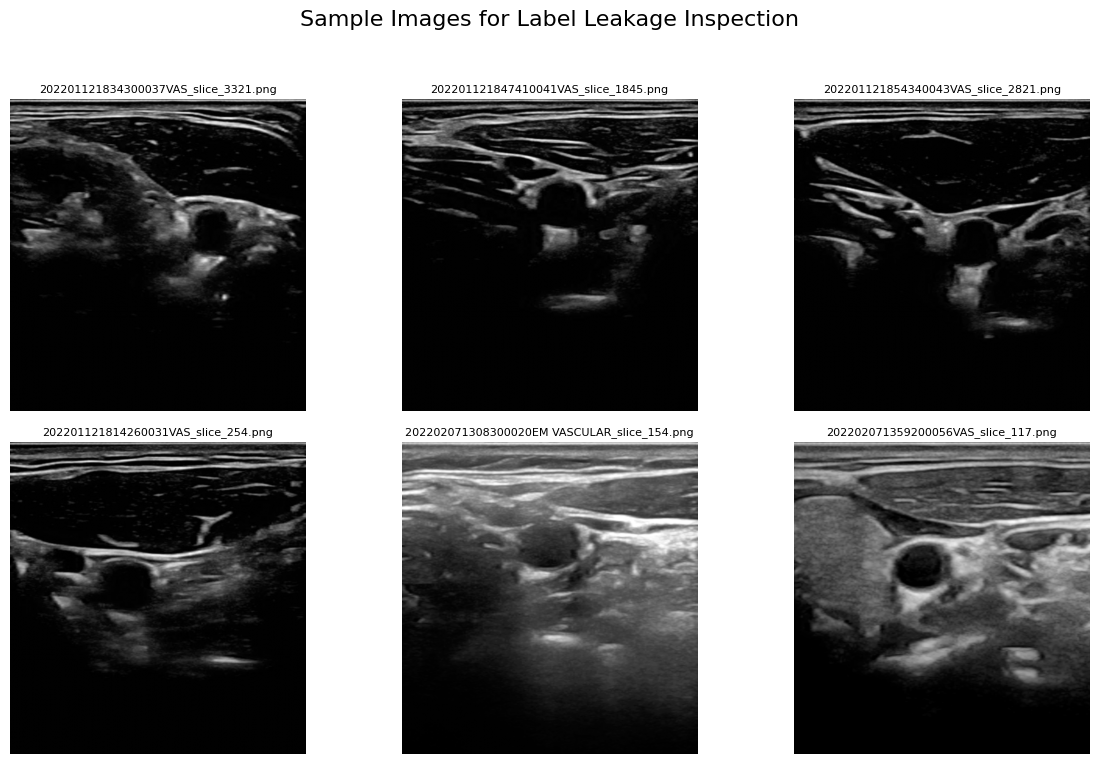

In [ ]:
n_display = 6
random_indices = np.random.RandomState(RANDOM_STATE).choice(len(sample_pairs), n_display, replace=False)

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i, sample_idx_in_sample_pairs in enumerate(random_indices):
    original_train_pair_idx = sample_pairs[sample_idx_in_sample_pairs]
    img_path, _ = train_pairs[original_train_pair_idx]

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        img_full = cv2.imread(img_path)
        if img_full is not None:
            img = img_full[:, :, 0]
        else:
            print(f"Warning: Could not read image {img_path}. Skipping.")
            continue

    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(Path(img_path).name, fontsize=8)
    axes[i].axis('off')

fig.suptitle('Sample Images for Label Leakage Inspection', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(FIGURES_DIR / 'label_leakage_inspection.png', dpi=150, bbox_inches='tight')
plt.show()


In [ ]:
high_risk_count = 0
normal_count = 0

if imts:
    total_valid_imts = len(imts)
    for imt_val in imts:
        if imt_val >= IMT_HIGH_RISK_MM:
            high_risk_count += 1
        else:
            normal_count += 1

    high_risk_percentage = (high_risk_count / total_valid_imts) * 100
    normal_percentage = (normal_count / total_valid_imts) * 100

    print(f"Total valid IMT measurements: {total_valid_imts}")
    print(f"High-risk samples (IMT >= {IMT_HIGH_RISK_MM} mm): {high_risk_count} ({high_risk_percentage:.2f}%)")
    print(f"Normal samples (IMT < {IMT_HIGH_RISK_MM} mm): {normal_count} ({normal_percentage:.2f}%)")
else:
    print("No valid IMT values were calculated to assess class imbalance.")


Total valid IMT measurements: 100
High-risk samples (IMT >= 0.9 mm): 100 (100.00%)
Normal samples (IMT < 0.9 mm): 0 (0.00%)


In [ ]:
import pywt

class MedicalDataCleaner:

    def __init__(self, clahe_clip_limit=2.0, clahe_grid_size=(8, 8), dwt_wavelet="db4", dwt_level=1, dwt_mode="soft", dwt_threshold_scale=1.0):
        self.clahe_clip_limit = clahe_clip_limit
        self.clahe_grid_size = clahe_grid_size
        self.dwt_wavelet = dwt_wavelet
        self.dwt_level = dwt_level
        self.dwt_mode = dwt_mode
        self.dwt_threshold_scale = dwt_threshold_scale

    def _clahe(self, img):
        img = np.asarray(img, dtype=np.float64)
        if img.max() > 1.0:
            img = img / (img.max() + 1e-8)
        img_uint8 = (np.clip(img, 0, 1) * 255).astype(np.uint8)
        clahe = cv2.createCLAHE(clipLimit=self.clahe_clip_limit, tileGridSize=self.clahe_grid_size)
        if img_uint8.ndim == 2:
            out = clahe.apply(img_uint8)
        else:
            lab = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2LAB)
            lab[:,:,0] = clahe.apply(lab[:,:,0])
            out = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
        return out.astype(np.float64) / 255.0

    def _dwt_denoise_2d(self, img):
        coeffs = pywt.wavedec2(img, self.dwt_wavelet, level=self.dwt_level)
        cA, detail_coeffs = coeffs[0], list(coeffs[1:])

        sigma = np.median(np.abs(cA)) / 0.6745 if cA.size > 0 else 1.0
        thresh_arg = max(1.0, cA.size)
        thresh = self.dwt_threshold_scale * sigma * np.sqrt(2 * np.log(thresh_arg))

        thresholded_detail_coeffs = []
        for level_coeffs in detail_coeffs:
            thresholded_level = []
            for d in level_coeffs:
                if d is not None:
                    thresholded_level.append(pywt.threshold(d, thresh, mode=self.dwt_mode))
                else:
                    thresholded_level.append(None)
            thresholded_detail_coeffs.append(tuple(thresholded_level))

        denoised_img = pywt.waverec2([cA] + thresholded_detail_coeffs, self.dwt_wavelet)

        return denoised_img[: img.shape[0], : img.shape[1]]

    def _dwt_denoise(self, img):
        img = np.asarray(img, dtype=np.float64)
        if img.ndim == 3:
            return np.stack([self._dwt_denoise_2d(img[..., c]) for c in range(img.shape[-1])], axis=-1)
        return self._dwt_denoise_2d(img)

    def __call__(self, img: np.ndarray, apply_clahe: bool = True, apply_dwt: bool = False) -> np.ndarray:
        processed_image = img.astype(np.float64)
        if apply_clahe:
            processed_image = self._clahe(processed_image)
        if apply_dwt:
            processed_image = self._dwt_denoise(processed_image)
        return processed_image.astype(np.float32)

cleaner = MedicalDataCleaner()


In [ ]:
IMG_SIZE = (224, 224)

def load_and_prepare(img_path, mask_path, cleaner, size=IMG_SIZE):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        img_full = cv2.imread(img_path)
        if img_full is not None:
            img = img_full[:, :, 0]
        else:
            print(f"Warning: Could not read image {img_path}. Skipping this pair.")
            return None, None

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        mask_full = cv2.imread(mask_path)
        if mask_full is not None:
            mask = mask_full[:, :, 0]
        else:
            print(f"Warning: Could not read mask {mask_path} (for image {img_path}). Skipping this pair.")
            return None, None

    img = img.astype(np.float32) / (np.max(img) + 1e-8)
    img = cleaner(img, apply_clahe=True, apply_dwt=True)
    img = cv2.resize(img, (size[1], size[0]), interpolation=cv2.INTER_LINEAR)
    mask = cv2.resize(mask, (size[1], size[0]), interpolation=cv2.INTER_NEAREST)
    mask = (mask > 127).astype(np.float32)
    return img[None], mask[None]

def load_split(pairs, cleaner, size=IMG_SIZE):
    X, y = [], []
    for img_path, mask_path in pairs:
        xi, yi = load_and_prepare(img_path, mask_path, cleaner, size)
        if xi is not None and yi is not None:
            X.append(xi)
            y.append(yi)
    if not X:
        return np.array([], dtype=np.float32).reshape(0, 1, size[0], size[1]), np.array([], dtype=np.float32).reshape(0, 1, size[0], size[1])
    return np.stack(X, axis=0).astype(np.float32), np.stack(y, axis=0).astype(np.float32)

X_train, y_train = load_split(train_pairs, cleaner)
X_val, y_val = load_split(val_pairs, cleaner)
X_test, y_test = load_split(test_pairs, cleaner)
spacing_mm = 0.04
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}, spacing_mm_per_pixel: {spacing_mm}")


Train: (770, 1, 224, 224), Val: (165, 1, 224, 224), Test: (165, 1, 224, 224), spacing_mm_per_pixel: 0.04


In [ ]:
sample_img_path = train_pairs[0][0]

original_img = cv2.imread(sample_img_path, cv2.IMREAD_GRAYSCALE)
if original_img is None:
    img_full = cv2.imread(sample_img_path)
    if img_full is not None:
        original_img = img_full[:, :, 0]
    else:
        print(f"Warning: Could not read image {sample_img_path}. Cannot generate comparison.")
        original_img = None

if original_img is not None:
    img_for_cleaner = original_img.astype(np.float32) / (np.max(original_img) + 1e-8)
    sample_preprocessed_image = cleaner(img_for_cleaner, apply_clahe=True, apply_dwt=True)
    sample_preprocessed_image = cv2.resize(sample_preprocessed_image, (IMG_SIZE[1], IMG_SIZE[0]), interpolation=cv2.INTER_LINEAR)
    print("Sample original and preprocessed images prepared.")
else:
    sample_preprocessed_image = None
    print("Failed to prepare sample images for visualization.")


Sample original and preprocessed images prepared.


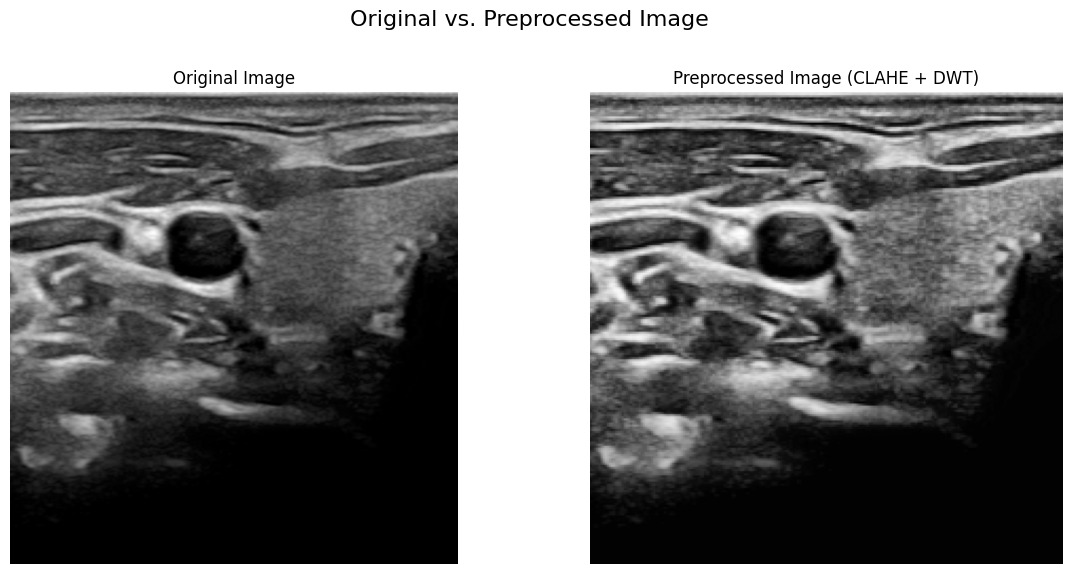

In [19]:
if 'original_img' in globals() and 'sample_preprocessed_image' in globals():
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(original_img, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(sample_preprocessed_image, cmap='gray')
    axes[1].set_title('Preprocessed Image (CLAHE + DWT)')
    axes[1].axis('off')

    plt.suptitle('Original vs. Preprocessed Image', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(FIGURES_DIR / 'original_vs_preprocessed.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("Original or preprocessed image data not found. Please ensure previous visualization cells have run.")

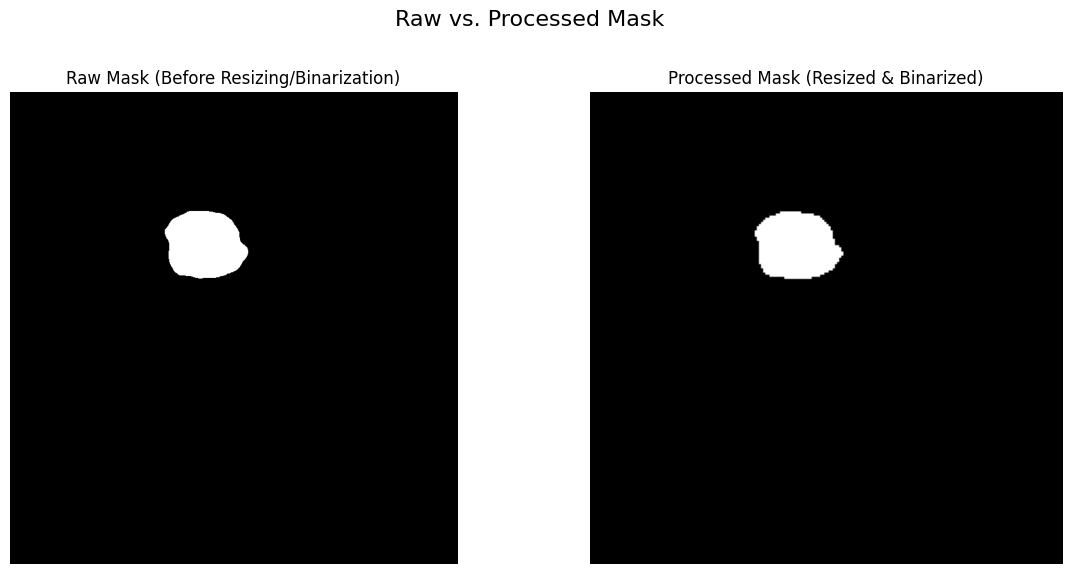

In [ ]:
if train_pairs and y_train.shape[0] > 0:
    original_mask_path = train_pairs[0][1]

    raw_mask = cv2.imread(original_mask_path, cv2.IMREAD_GRAYSCALE)
    if raw_mask is None:
        raw_mask_full = cv2.imread(original_mask_path)
        if raw_mask_full is not None:
            raw_mask = raw_mask_full[:, :, 0]
        else:
            print(f"Warning: Could not read raw mask {original_mask_path}. Skipping visualization.")
            raw_mask = None

    sample_processed_mask = y_train[0, 0, :, :]

    if raw_mask is not None and sample_processed_mask is not None:
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        axes[0].imshow(raw_mask, cmap='gray')
        axes[0].set_title('Raw Mask (Before Resizing/Binarization)')
        axes[0].axis('off')

        axes[1].imshow(sample_processed_mask, cmap='gray')
        axes[1].set_title('Processed Mask (Resized & Binarized)')
        axes[1].axis('off')

        plt.suptitle('Raw vs. Processed Mask', fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig(FIGURES_DIR / 'raw_vs_processed_mask.png', dpi=150, bbox_inches='tight')
        plt.show()
    else:
        print("Could not load both raw and processed mask for comparison.")
else:
    print("No training pairs or processed masks available for comparison.")


### Model initialization (Swin-UNETR)

Architecture from MONAI. Key hyperparameters: **feature_size** (e.g. 48), **patch_size** (usually 2 for Swin), **num_heads** (e.g. 12). Optionally load pretrained weights for fine-tuning (e.g. from a medical imaging checkpoint).

In [ ]:
import torch
from monai.networks.nets import SwinUNETR

img_size = IMG_SIZE

model = SwinUNETR(
    img_size=img_size,
    in_channels=1,
    out_channels=2,
    spatial_dims=2,
    feature_size=48,
    num_heads=(3, 6, 12, 24),
    use_checkpoint=False,
).to(device)

pretrained_path = MODEL_DIR / "model_swinvit.pt"
if pretrained_path.exists():
    state = torch.load(pretrained_path, map_location=device)
    model.load_state_dict(state.get("model", state), strict=False)
    print("✅ Loaded pretrained weights for fine-tuning.")

print(f"Swin-UNETR 2D model, params: {sum(p.numel() for p in model.parameters()):,}")


/usr/local/Caskroom/miniforge/base/envs/strokelink/lib/python3.11/site-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


Swin-UNETR 2D model, params: 25,137,980


In [ ]:
import torch
import numpy as np
from monai.losses import DiceLoss
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

FOREGROUND_WEIGHT = 30.0
SWAP_CHANNELS = False
dice_loss_fn = DiceLoss(include_background=False, softmax=True, to_onehot_y=True)
ce_loss_fn = torch.nn.CrossEntropyLoss(weight=torch.tensor([1.0, FOREGROUND_WEIGHT], dtype=torch.float32, device=device))
USE_DICE_ONLY = True
def criterion(out, target_long, target_1ch):
    loss = dice_loss_fn(out, target_1ch)
    if not USE_DICE_ONLY:
        loss = loss + ce_loss_fn(out, target_long)
    return loss
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.001)
max_epochs = 50
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs, eta_min=1e-5)
train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train.squeeze(1).astype(np.int64)))
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)

dice_metric = DiceMetric(include_background=False, reduction="mean_batch", ignore_empty=True)
train_loss_history, val_dice_history, val_imt_mae_history = [], [], []
best_val_dice, best_epoch, patience_counter = 0.0, 0, 0
best_state = None
early_stop_patience = 10


NameError: name 'model' is not defined

In [ ]:
for epoch in range(max_epochs):
    model.train()
    epoch_loss = 0
    
    for batch_data in train_loader:
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_train_loss = epoch_loss / len(train_loader)
    train_loss_history.append(avg_train_loss)
    
    model.eval()
    val_dice_scores = []
    val_imt_errors = []
    
    with torch.no_grad():
        for i in range(0, len(X_val), 4):
            batch_x = torch.from_numpy(X_val[i:i+4]).to(device)
            batch_y = torch.from_numpy(y_val[i:i+4]).to(device)
            
            val_outputs = model(batch_x)
            val_pred_soft = torch.softmax(val_outputs, dim=1)
            
            if SWAP_CHANNELS:
                val_pred_soft = val_pred_soft[:, [1, 0], :, :]
            
            batch_y_labels = batch_y.squeeze(1).long()
            batch_y_onehot = torch.nn.functional.one_hot(batch_y_labels, num_classes=2).permute(0, 3, 1, 2).float()
            
            p_fg = val_pred_soft[:, 1].float()
            y_fg = batch_y_onehot[:, 1].float()
            dice_scores = 2 * (p_fg * y_fg).sum(dim=(1,2)) / ((p_fg + y_fg).sum(dim=(1,2)) + 1e-8)
            val_dice_scores.extend(dice_scores.cpu().numpy())
            
            pred_masks = val_pred_soft.argmax(dim=1).cpu().numpy()
            gt_masks = batch_y.squeeze(1).cpu().numpy().astype(np.int32)
            
            for pred_mask, gt_mask in zip(pred_masks, gt_masks):
                pred_imt = imt_mm_from_mask(pred_mask, spacing_mm, wall_label=1)
                gt_imt = imt_mm_from_mask(gt_mask, spacing_mm, wall_label=1)
                if np.isfinite(pred_imt) and np.isfinite(gt_imt):
                    val_imt_errors.append(abs(pred_imt - gt_imt))
    
    val_dice = np.mean(val_dice_scores) if val_dice_scores else 0.0
    val_imt_mae = np.mean(val_imt_errors) if val_imt_errors else np.nan
    
    val_dice_history.append(val_dice)
    val_imt_mae_history.append(val_imt_mae)
    
    scheduler.step()
    
    print(f"Epoch {epoch+1}/{max_epochs} | Train Loss: {avg_train_loss:.4f} | Val Dice: {val_dice:.4f} | Val IMT MAE: {val_imt_mae:.4f} mm | LR: {scheduler.get_last_lr()[0]:.6f}")
    
    if val_dice > best_val_dice:
        best_val_dice = val_dice
        best_epoch = epoch
        best_state = model.state_dict().copy()
        patience_counter = 0
        print(f"  ✓ New best Dice: {best_val_dice:.4f}")
    else:
        patience_counter += 1
        if patience_counter >= early_stop_patience:
            print(f"Early stopping at epoch {epoch+1} (best: {best_val_dice:.4f} at epoch {best_epoch+1})")
            break

if best_state is not None:
    model.load_state_dict(best_state)
    print(f"\nRestored best model from epoch {best_epoch+1} (Dice: {best_val_dice:.4f})")


In [ ]:
model.eval()

def imt_mae_mm(pred_masks: np.ndarray, gt_masks: np.ndarray, spacing_mm_per_pixel: float, lumen_label: int = 2, wall_label: int = 1) -> float:
    """
    Calculates the Mean Absolute Error (MAE) of IMT between predicted and ground truth masks.

    Args:
        pred_masks (np.ndarray): Predicted segmentation masks (binary, where `wall_label` indicates the wall).
        gt_masks (np.ndarray): Ground truth segmentation masks (binary, where `wall_label` indicates the wall).
        spacing_mm_per_pixel (float): Physical distance represented by each pixel in mm.
        lumen_label (int): Label for the lumen in the mask (not used in IMT calculation but kept for consistency if needed elsewhere).
        wall_label (int): Label for the wall in the mask.

    Returns:
        float: Mean Absolute Error of IMT in millimeters.
    """
    pred_imts = []
    gt_imts = []

    for i in range(pred_masks.shape[0]):
        pred_imt = imt_mm_from_mask(pred_masks[i], spacing_mm_per_pixel, wall_label=wall_label)
        gt_imt = imt_mm_from_mask(gt_masks[i], spacing_mm_per_pixel, wall_label=wall_label)

        if np.isfinite(pred_imt) and np.isfinite(gt_imt):
            pred_imts.append(pred_imt)
            gt_imts.append(gt_imt)

    if not pred_imts:
        return np.nan

    return np.mean(np.abs(np.array(pred_imts) - np.array(gt_imts)))

if X_test.shape[0] == 0:
    print("No test data available for evaluation. Skipping test Dice and IMT MAE calculation.")
else:
    dice_metric = DiceMetric(include_background=False, reduction="mean")
    with torch.no_grad():
        pred = model(torch.from_numpy(X_test).to(device))
        pred_soft = torch.softmax(pred, dim=1)
        try:
            if SWAP_CHANNELS:
                pred_soft = pred_soft[:, [1, 0], :, :]
        except NameError:
            pass

        y_test_labels = torch.from_numpy(y_test.squeeze(1).astype(np.int64)).to(device)
        y_onehot = torch.nn.functional.one_hot(y_test_labels, num_classes=2).permute(0, 3, 1, 2).float()
        p_fg = pred_soft[:, 1].float()
        y_fg = y_onehot[:, 1].float()
        dice_per_s = 2 * (p_fg * y_fg).sum(dim=(1,2)) / ((p_fg + y_fg).sum(dim=(1,2)) + 1e-8)
        pred_class = pred_soft.argmax(dim=1).cpu().numpy()

    test_dice = dice_per_s.mean().item()
    try:
        imt_mae = imt_mae_mm(pred_class, y_test.squeeze(1).astype(np.int32), spacing_mm, lumen_label=2, wall_label=1)
        imt_str = f"{imt_mae:.4f}" if np.isfinite(imt_mae) else "N/A"
    except NameError:
        imt_mae = np.nan
        imt_str = "N/A (imt_mae_mm not defined)"

    print(f"Test Dice: {test_dice:.4f}  |  IMT MAE (mm): {imt_str}")
    print(f"StrokeLink triage: IMT ≥ {IMT_HIGH_RISK_MM} mm = high risk (refer to Gasabo District)")


In [ ]:
model_path = MODEL_DIR / "carotid_swin_unetr_2d.pt1"
torch.save({
    "model": model.state_dict(), "img_size": img_size, "in_channels": 1, "out_channels": 2,
    "imt_high_risk_mm": IMT_HIGH_RISK_MM, "spacing_mm_per_pixel": spacing_mm
}, model_path)
print(f"Model saved to {model_path} (for FastAPI + Flutter app)")

Model saved to models/carotid_swin_unetr_2d.pt (for FastAPI + Flutter app)
